#Summary Statistics Regression Notebook 

In [1]:
#Import libraries 

#matplotlib for plotting
import matplotlib.pyplot as plt
import matplotlib as mpl 
mpl.rcParams['pdf.fonttype'] = 42

#pandas for working with dataframes
import pandas as pd 
from pandas import DataFrame, read_csv
#numpy
import numpy as np
#csv reader
import csv

import palettable as pal
from palettable.colorbrewer.qualitative import Paired_12

#for the linear regressions
from scipy import stats
import pylab

# Enable inline plotting
%matplotlib inline

/Users/eleanorbors/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/pytz/__init__.py:29: UserWarning: Module PIL was already imported from /Users/eleanorbors/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/PIL/__init__.pyc, but /Users/eleanorbors/anaconda/lib/python2.7/site-packages is being added to sys.path
  from pkg_resources import resource_stream


##Define input files, colors, distance dictionary, and allelic richness values

-I Have a lot of different options for the input file commented out

-Definte the distance dictionaries, here there are three different ones

-Manually enter the Allelic Richness that were calculated in PopGenKit in R.  (Stacks doesn't calculate it) 

-Define the colors for each population so the remain consistent 

In [2]:
#File paths to stacks populations outputs
b9_p8_r80_summary_filepath = '/Users/eleanorbors/Desktop/Analysis/Lionfish_Stacks_Files/stacks_1.35/batch_9/populations_p8_r80/batch_9.sumstats_summary_variant.tsv'
b9_p8_r80_sumstats_filepath = '/Users/eleanorbors/Desktop/Analysis/Lionfish_Stacks_Files/stacks_1.35/batch_9/populations_p8_r80/batch_9.sumstats.tsv'

#Define a population list:
population_list = ['FLO', 'BAH', 'CAY', 'JAM', 'MEX', 'BEL', 'HON', 'DOM', 'USV']

###Three different options for distance dictionary: 
#Euclidian distances calcuated in Google Earth (straight lines between Lat/Long coordinates)
euclid_dist_dic = {'FLO':0.0, 'BAH':406, 'USV':1816, 'DOM':1409, 'JAM':885, 'CAY':678, 'MEX':906, 'HON':1222, 'BEL':1148}
#GIS through-ocean distances (calculated by CAM)--shortest distance through water
ocean_dist_dic = {'FLO':0.0, 'BAH':409.01, 'USV':1816.4, 'DOM':1518.2, 'JAM':1303.79, 'CAY':1084.9, 'MEX':889.1, 'HON':1266.5, 'BEL':1127.8}
#Dictionary with GIS through-ocean data modified to go around the East side of Cuba
modified_ocean_dist_dic = {'FLO':0.0, 'BAH':409.015, 'USV':1816.4, 'DOM':1518.20, 'JAM':1303.79, 'CAY':1556.56, 'MEX':2122.87, 'HON':2180.68, 'BEL':2239.69}

#NOTE: These are Allelic Richnesses calculated in R using PopGenKit FOR THE b9 p8 r80 Dataset! ********
arich_dic = {'FLO': 1.419610, 'BAH': 1.450788, 'USV': 1.409640, 'DOM': 1.401103, 'JAM': 1.404979, 'CAY': 1.389767, 'MEX': 1.405664, 'HON': 1.413079, 'BEL': 1.391807}

#Define colors for figures (keep same across all manuscript figures)
colors = {'CAY': '#F46D43', 'BEL': '#ABDDA4', 'DOM': '#5E4FA2', 'HON': '#FEE08B', 'NC': '#FF7F00', 'USV': '#FFFFBF', 
          'JAM': '#3288BD', 'FLO': '#4A4A4A', 'LIS': '#CAB2D6', 'BER': '#6A3D9A', 'MEX': '#FDAE61', 'BAH': '#9E0142'}

In [3]:
####Other possible input files to compare STACKS runs 

#file_path = '/Users/eleanorbors/Desktop/Analysis/Lionfish_Stacks_Files/stacks_1.35/batch_8/nM2_populations_p9_r80/batch_8.sumstats_ordered.tsv'
#summary_file_path = '/Users/eleanorbors/Desktop/Analysis/Lionfish_Stacks_Files/stacks_1.35/batch_9/nM3_populations_p9_r80_randomsnp_ordered/batch_9.sumstats_summary_variant.tsv'
#b9_r70_summary_filefath = '/Users/eleanorbors/Desktop/Analysis/Lionfish_Stacks_Files/stacks_1.35/batch_9/populations_p9_r70_randomsnp/batch_9.sumstats_summary_variant.tsv'
#b11_summary_file = '/Users/eleanorbors/Desktop/Analysis/Lionfish_Stacks_Files/stacks_1.35/batch_11/populations_p9_r80_randomsnp/batch_11.sumstats_summary_variant.tsv'
#b11_r70_summary_filepath = '/Users/eleanorbors/Desktop/Analysis/Lionfish_Stacks_Files/stacks_1.35/batch_11/populations_p9_r70/batch_11.sumstats_summary_variant.tsv'
#b9_p7_r80_summary_filepath = '/Users/eleanorbors/Desktop/Analysis/Lionfish_Stacks_Files/stacks_1.35/batch_9/populations_p7_r80/batch_9.sumstats_summary_variant.tsv'


###This dictionary you do not use, but it's saved here for posterity: 
#FROM Google Earth: {'FLO':0.0, 'BAH':442, 'USV':1874, 'DOM':1609, 'JAM':1277, 'CAY':1647, 'MEX':2256, 'HON':2248, 'BEL':2347}


##Define Functions

In [4]:
######
##Make main summary statistics dataframe.

def make_sum_stats_dataframe(input_file, df_name, dist_dictionary, pop_count=9):
    df_name = pd.read_csv(input_file, skiprows=pop_count, sep='\t')
    #Rename the columns 
    df_name.rename(columns={'# Batch ID ' : 'batch'}, inplace=True)
    df_name.rename(columns={'Locus ID': 'locus_id'}, inplace=True)
    df_name.rename(columns={'P Nuc': 'P_nuc'}, inplace=True)
    df_name.rename(columns={'Q Nuc': 'Q_nuc'}, inplace=True)
    df_name.rename(columns={'Pop ID': 'pop'}, inplace=True)
    df_name.rename(columns={'Obs Het': 'Hobs'}, inplace=True)
    df_name.rename(columns={'Exp Het': 'Hexp'}, inplace = True)
    distance_values = []
    for i in df_name['pop']:
        distance_values.append(dist_dictionary[i])
    df_name['distance']=distance_values
    return df_name

######
##Make dataframe of the sumstats summary data (averages by population) as provided by STACKS

def make_avg_sumstats_dataframe(avg_sumstats_input_file, summary_df_name, dist_dictionary, pop_count=9):
    summary_df_name = pd.read_csv(avg_sumstats_input_file, skiprows=1, sep='\t')
    summary_df_name.rename(columns={'# Pop ID': 'pop'}, inplace=True)
    summary_df_name.rename(columns={'Obs Het': 'Hobs'}, inplace=True)
    summary_df_name.rename(columns={'Exp Het': 'Hexp'}, inplace=True)
    summary_df_name.rename(columns={'Var.2': 'Var_Hobs'}, inplace=True)
    summary_df_name.rename(columns={'StdErr.2': 'StdErr_Hobs'}, inplace=True)
    #Define an empty list of distance values:
    summary_distance_values = []
    for i in summary_df_name['pop']:
        #print i
        #print dist_dictionary[i]
        summary_distance_values.append(dist_dictionary[i])
    print summary_distance_values
    #Add allelic richness info
    summary_arich_values = []
    for i in summary_df_name['pop']:
        summary_arich_values.append(arich_dic[i])
    print summary_arich_values
    summary_df_name['distance']=summary_distance_values
    summary_df_name['a_richness']=summary_arich_values
    summary_df_name = summary_df_name.sort('distance', ascending=True)
    summary_df_name['Het_difference'] = summary_df_name["Hexp"] - summary_df_name["Hobs"]
    #Het_differences
    return summary_df_name

######
##
######
##FUNCTION FOR GRAPHING WITH REGRESSION 
#WANT TO CHANGE TO HAVE OPTIONAL REGRESSION CALCULATION! Might need to do that with an if/then statement

#Note that the x/y min/max and location of the legend are changable but have defaults
def plot_genetic_statistic_with_regression(summary_df_name, x_data, y_data, x_label, y_label, color_dic, plot_title, figure_output_path, legend_location='upper right', ymax = 0.14, ymin = 0.058, xmax = 2500, xmin = -200):
    #Calculate linear regression with data 
    slope, intercept, r_value, p_value, slope_std_error = stats.linregress(summary_df_name[x_data], summary_df_name[y_data])
    #Will print out regression information: 
    predict_y = intercept + slope * summary_df_name[x_data]
    pred_error =  - predict_y
    degrees_of_freedom = len(summary_df_name[x_data]) - 2
    residual_std_error = np.sqrt(np.sum(pred_error**2) / degrees_of_freedom)
    #Will print the r-squared and the p-value to screen: 
    print("r-squared:", r_value**2)
    print("p-value:", p_value)
    print('slope:', slope)
    #Define x and y for plotting later:
    reg_x = np.linspace(-500,3000) 
    reg_y = (slope * reg_x) + intercept
    ##PLOT ON THE OTHER GRAPH
    groups = summary_df_name.groupby('pop', sort=False)
    fig,ax= plt.subplots()
    fig.set_size_inches(10,8)
    for key, group in groups:
        group.plot(kind='scatter', x=x_data, 
                   y=y_data, color = color_dic[key], ax=ax, label = key, marker = 'o', s = 250, edgecolors='black', fontsize = 14)
    #The next line plots the regression line: 
    pylab.plot(reg_x, reg_y, 'k--')
    ax.set_ylim([ymin,ymax])
    ax.set_xlim([xmin,xmax])
    ax.legend(loc='center left', fontsize=14, ncol=1, scatterpoints=1, bbox_to_anchor=(1, 0.5))    
    plt.xlabel(x_label, fontsize = 16)
    plt.ylabel(y_label, fontsize = 16)
    plt.title(plot_title, fontsize = 20, y=1.05, loc = 'left')
    fig.savefig(figure_output_path, format='pdf', bbox_inches = 'tight')
    
def plot_genetic_statistic_NO_regression(summary_df_name, x_data, y_data, x_label, y_label, color_dic, plot_title, figure_output_path,legend_location='upper right',ymax = 0.14, ymin = 0.058, xmax = 2500, xmin = -200):
    ##PLOT ON THE OTHER GRAPH
    groups = summary_df_name.groupby('pop', sort=False)
    fig,ax= plt.subplots()
    fig.set_size_inches(10,8)
    for key, group in groups:
        group.plot(kind='scatter', x=x_data, 
                   y=y_data, color = color_dic[key], ax=ax, label = key, marker = 'o', s = 250, edgecolors='black', fontsize = 14)
    ax.set_ylim([ymin,ymax])
    ax.set_xlim([xmin,xmax])
    ax.legend(loc='center left', fontsize=14, ncol=1, scatterpoints=1, bbox_to_anchor=(1, 0.5))    
    plt.xlabel(x_label, fontsize = 16)
    plt.ylabel(y_label, fontsize = 16)
    plt.title(plot_title, fontsize = 20, y=1.05, loc='left')
    fig.savefig(figure_output_path, format='pdf', bbox_inches = 'tight')

##Make dataframes, run pertinent functions with your chosen data

In [5]:
b9_p8_r80_avg_sumstats_euc_dist = make_avg_sumstats_dataframe(b9_p8_r80_summary_filepath, 'b9_p8_r80_avg_sumstats_euc_dist', euclid_dist_dic)
b9_p8_r80_avg_sumstats_euc_dist

[0.0, 406, 678, 885, 1409, 906, 1148, 1222, 1816]
[1.41961, 1.450788, 1.389767, 1.404979, 1.401103, 1.405664, 1.391807, 1.413079, 1.40964]


,pop,Private,Num Indv,Var,StdErr,P,Var.1,StdErr.1,Hobs,Var_Hobs,...,StdErr.5,Pi,Var.6,StdErr.6,Fis,Var.7,StdErr.7,distance,a_richness,Het_difference
0,FLO,421,10.4786,0.4421,0.0059,0.9053,0.0190,0.0012,0.1177,0.0283,...,0.0015,0.1402,0.0330,0.0016,0.0643,26.0907,0.0059,0,1.419610,0.0157
1,BAH,620,8.6021,0.2396,0.0045,0.9024,0.0186,0.0012,0.0997,0.0207,...,0.0016,0.1476,0.0334,0.0017,0.1304,25.8688,0.0045,406,1.450788,0.0393
2,CAY,478,10.0495,0.5795,0.0069,0.9090,0.0186,0.0012,0.0718,0.0137,...,0.0016,0.1351,0.0329,0.0017,0.1786,28.6623,0.0069,678,1.389767,0.0565
3,JAM,746,13.0478,0.5895,0.0070,0.9077,0.0180,0.0012,0.0873,0.0163,...,0.0015,0.1369,0.0311,0.0016,0.1498,25.5384,0.0070,885,1.404979,0.0443
5,MEX,381,6.5103,0.2499,0.0047,0.9096,0.0192,0.0013,0.0772,0.0177,...,0.0016,0.1367,0.0357,0.0018,0.1474,30.4555,0.0047,906,1.405664,0.0489
6,BEL,839,17.7624,1.4472,0.0110,0.9057,0.0185,0.0012,0.0678,0.0098,...,0.0016,0.1377,0.0307,0.0016,0.2272,24.3949,0.0110,1148,1.391807,0.0660
7,HON,781,14.6673,0.9588,0.0088,0.9056,0.0181,0.0012,0.0882,0.0155,...,0.0015,0.1397,0.0309,0.0016,0.1564,24.3191,0.0088,1222,1.413079,0.0466
4,DOM,656,14.6043,0.9746,0.0089,0.9070,0.0181,0.0012,0.0802,0.0138,...,0.0015,0.1373,0.0308,0.0016,0.1779,25.2780,0.0089,1409,1.401103,0.0523
8,USV,857,13.7671,0.5652,0.0073,0.9069,0.0180,0.0013,0.0788,0.0129,...,0.0016,0.1379,0.0307,0.0017,0.1828,24.5860,0.0073,1816,1.409640,0.0541


In [6]:
## Make the summary sumstats dataframe with (1) Euclidian Distance, (2) the Google-Earth generated distances, (3) GIS distances

b9_p8_r80_avg_sumstats_euc_dist = make_avg_sumstats_dataframe(b9_p8_r80_summary_filepath, 'b9_p8_r80_avg_sumstats_euc_dist', euclid_dist_dic)

b9_p8_r80_avg_sumstats_ocean_dist = make_avg_sumstats_dataframe(b9_p8_r80_summary_filepath, 'b9_p8_r80_avg_sumstats', ocean_dist_dic)

b9_p8_r80_avg_sumstats_modified_ocean_dist =  make_avg_sumstats_dataframe(b9_p8_r80_summary_filepath, 'b9_p8_r80_avg_sumstats_gis_dist', modified_ocean_dist_dic)

#Check one
b9_p8_r80_avg_sumstats_modified_ocean_dist

[0.0, 406, 678, 885, 1409, 906, 1148, 1222, 1816]
[1.41961, 1.450788, 1.389767, 1.404979, 1.401103, 1.405664, 1.391807, 1.413079, 1.40964]
[0.0, 409.01, 1084.9, 1303.79, 1518.2, 889.1, 1127.8, 1266.5, 1816.4]
[1.41961, 1.450788, 1.389767, 1.404979, 1.401103, 1.405664, 1.391807, 1.413079, 1.40964]
[0.0, 409.015, 1556.56, 1303.79, 1518.2, 2122.87, 2239.69, 2180.68, 1816.4]
[1.41961, 1.450788, 1.389767, 1.404979, 1.401103, 1.405664, 1.391807, 1.413079, 1.40964]


,pop,Private,Num Indv,Var,StdErr,P,Var.1,StdErr.1,Hobs,Var_Hobs,...,StdErr.5,Pi,Var.6,StdErr.6,Fis,Var.7,StdErr.7,distance,a_richness,Het_difference
0,FLO,421,10.4786,0.4421,0.0059,0.9053,0.0190,0.0012,0.1177,0.0283,...,0.0015,0.1402,0.0330,0.0016,0.0643,26.0907,0.0059,0.000,1.419610,0.0157
1,BAH,620,8.6021,0.2396,0.0045,0.9024,0.0186,0.0012,0.0997,0.0207,...,0.0016,0.1476,0.0334,0.0017,0.1304,25.8688,0.0045,409.015,1.450788,0.0393
3,JAM,746,13.0478,0.5895,0.0070,0.9077,0.0180,0.0012,0.0873,0.0163,...,0.0015,0.1369,0.0311,0.0016,0.1498,25.5384,0.0070,1303.790,1.404979,0.0443
4,DOM,656,14.6043,0.9746,0.0089,0.9070,0.0181,0.0012,0.0802,0.0138,...,0.0015,0.1373,0.0308,0.0016,0.1779,25.2780,0.0089,1518.200,1.401103,0.0523
2,CAY,478,10.0495,0.5795,0.0069,0.9090,0.0186,0.0012,0.0718,0.0137,...,0.0016,0.1351,0.0329,0.0017,0.1786,28.6623,0.0069,1556.560,1.389767,0.0565
8,USV,857,13.7671,0.5652,0.0073,0.9069,0.0180,0.0013,0.0788,0.0129,...,0.0016,0.1379,0.0307,0.0017,0.1828,24.5860,0.0073,1816.400,1.409640,0.0541
5,MEX,381,6.5103,0.2499,0.0047,0.9096,0.0192,0.0013,0.0772,0.0177,...,0.0016,0.1367,0.0357,0.0018,0.1474,30.4555,0.0047,2122.870,1.405664,0.0489
7,HON,781,14.6673,0.9588,0.0088,0.9056,0.0181,0.0012,0.0882,0.0155,...,0.0015,0.1397,0.0309,0.0016,0.1564,24.3191,0.0088,2180.680,1.413079,0.0466
6,BEL,839,17.7624,1.4472,0.0110,0.9057,0.0185,0.0012,0.0678,0.0098,...,0.0016,0.1377,0.0307,0.0016,0.2272,24.3949,0.0110,2239.690,1.391807,0.0660


In [7]:
df_sorted_Hobs = b9_p8_r80_avg_sumstats_ocean_dist.sort('Hobs', ascending=False)
df_sorted_Hexp = b9_p8_r80_avg_sumstats_ocean_dist.sort('Hexp', ascending=False)
df_sorted_Arich = b9_p8_r80_avg_sumstats_ocean_dist.sort('a_richness', ascending =False)

print 'Ordered by Observed Heterozygosity:\n', df_sorted_Hobs['pop']
print 'Ordered by Expected Heterozygosity:\n', df_sorted_Hexp['pop']
print 'Ordered by Allelic Richness:\n', df_sorted_Arich['pop']

Ordered by Observed Heterozygosity:
0    FLO
1    BAH
7    HON
3    JAM
4    DOM
8    USV
5    MEX
2    CAY
6    BEL
Name: pop, dtype: object
Ordered by Expected Heterozygosity:
1    BAH
7    HON
6    BEL
0    FLO
8    USV
4    DOM
3    JAM
2    CAY
5    MEX
Name: pop, dtype: object
Ordered by Allelic Richness:
1    BAH
0    FLO
7    HON
8    USV
5    MEX
3    JAM
4    DOM
6    BEL
2    CAY
Name: pop, dtype: object


('r-squared:', 0.69324261523469521)
('p-value:', 0.0053419115809388027)
('slope:', 1.4848691198432219e-05)


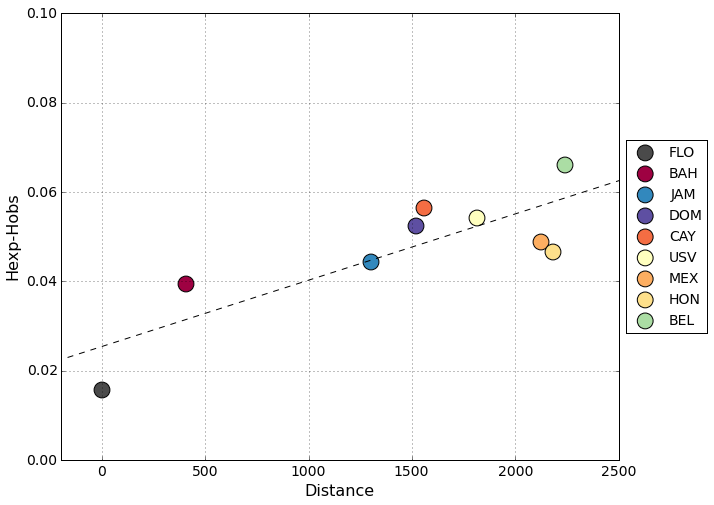

In [7]:
plot_genetic_statistic_with_regression(b9_p8_r80_avg_sumstats_modified_ocean_dist, 'distance', 'Het_difference', 'Distance', 'Hexp-Hobs', colors, "", '/Users/eleanorbors/Desktop/Manuscripts/Lionfish_ms1_modern/figures_for_paper/b9_p8_r80_Het_difference_vs_modifiedO_Distances.pdf',  legend_location='upper left', ymax = 0.1, ymin = 0.0)


('r-squared:', 0.46232472065982283)
('p-value:', 0.043890031544428422)
('slope:', -1.9284989445437319e-05)
('r-squared:', 0.53647703607073005)
('p-value:', 0.024817666141578144)
('slope:', -2.0294050360285324e-05)
('r-squared:', 0.74364541602607515)
('p-value:', 0.0027775943043187963)
('slope:', -1.6829555314450993e-05)


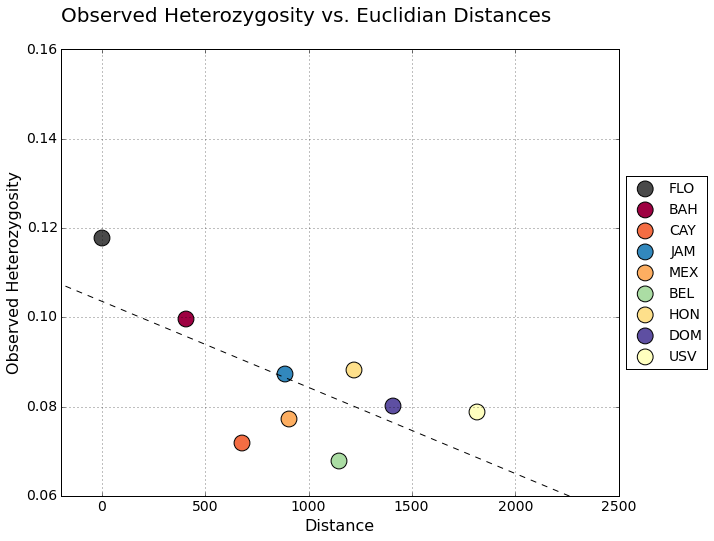

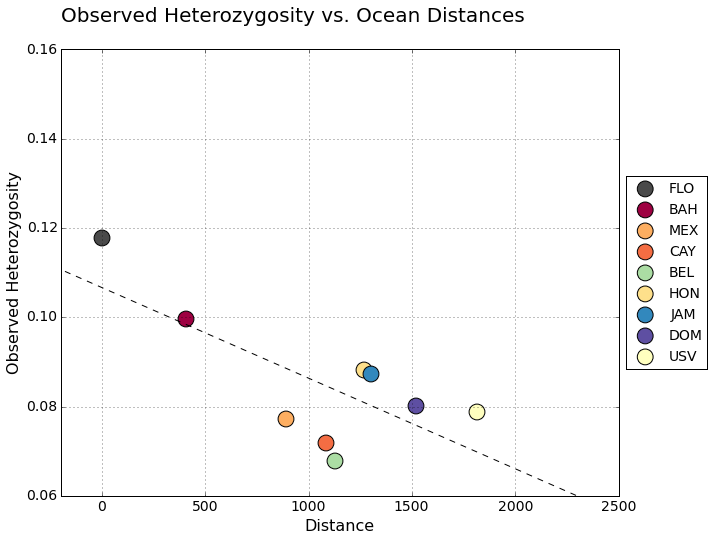

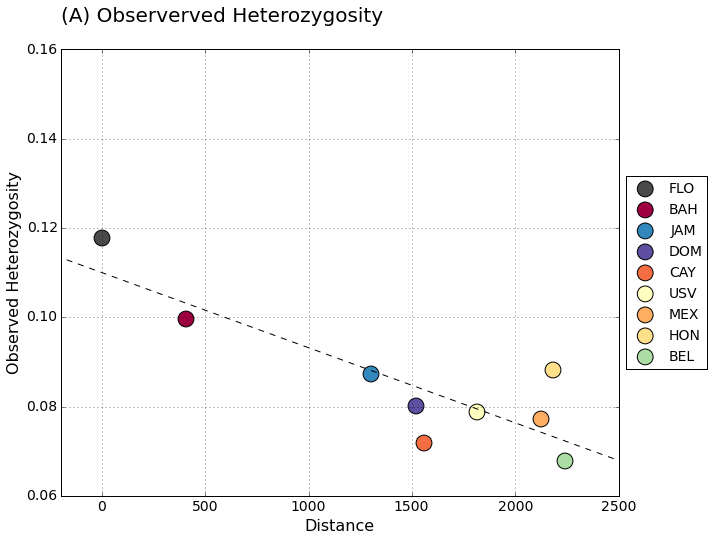

In [8]:
### HOBS FIGURES FOR THE THREE DISTANCE DICTIONARIES 

#Hobs with Euclidian distance 
plot_genetic_statistic_with_regression(b9_p8_r80_avg_sumstats_euc_dist, 'distance', 'Hobs', 'Distance', 'Observed Heterozygosity', colors, "Observed Heterozygosity vs. Euclidian Distances", '/Users/eleanorbors/Desktop/Manuscripts/Lionfish_ms1_modern/figures_for_paper/b9_p8_r80_Hobs_vs_EuclidianDistances.pdf', ymax = 0.16, ymin = 0.06)

#Hobs with GIS through-ocean distances
plot_genetic_statistic_with_regression(b9_p8_r80_avg_sumstats_ocean_dist, 'distance', 'Hobs', 'Distance', 'Observed Heterozygosity', colors, "Observed Heterozygosity vs. Ocean Distances", '/Users/eleanorbors/Desktop/Manuscripts/Lionfish_ms1_modern/figures_for_paper/b9_p8_r80_Hobs_vs_ocean_dist.pdf', ymax = 0.16, ymin = 0.06)


#Hobs with GIS through-ocean distance with modification around East side of Cuba
plot_genetic_statistic_with_regression(b9_p8_r80_avg_sumstats_modified_ocean_dist, 'distance', 'Hobs', "Distance", "Observed Heterozygosity", colors, "(A) Observerved Heterozygosity", '/Users/eleanorbors/Desktop/Manuscripts/Lionfish_ms1_modern/figures_for_paper/b9_p8_r80_Hobs_vs_modified_ocean_dist.pdf', ymax = 0.16, ymin = 0.06)



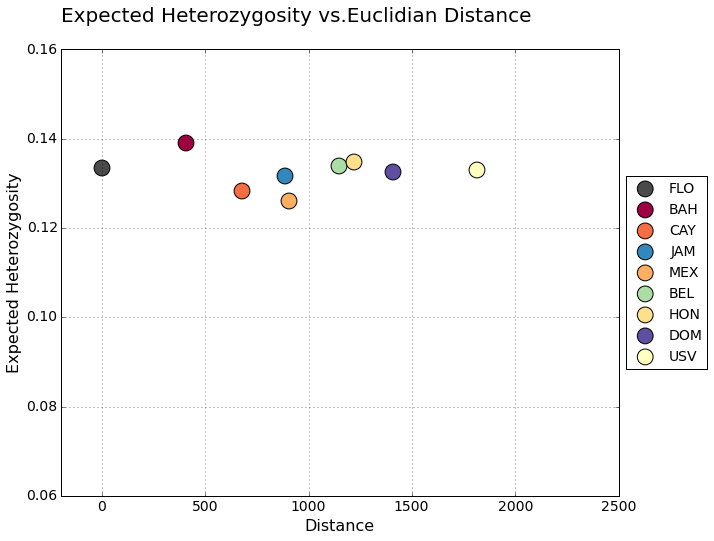

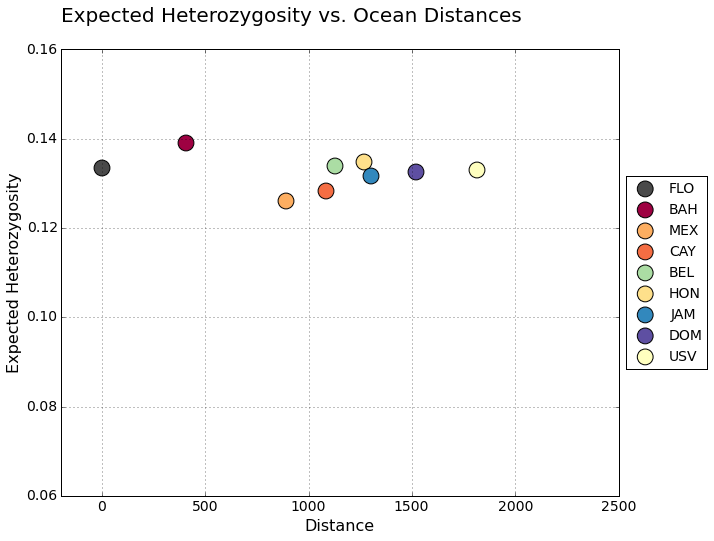

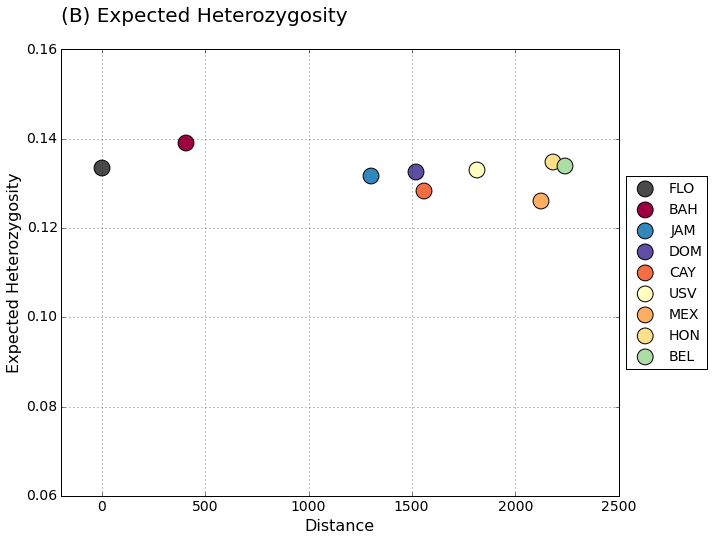

In [17]:
#Hexpected with euclidian distances 
plot_genetic_statistic_NO_regression(b9_p8_r80_avg_sumstats_euc_dist, 'distance', 'Hexp', "Distance", "Expected Heterozygosity", colors, "Expected Heterozygosity vs.Euclidian Distance", '/Users/eleanorbors/Desktop/Manuscripts/Lionfish_ms1_modern/figures_for_paper/b9_p8_r80_Hexp_vs_Euc_dist.pdf',legend_location='lower right', ymax = 0.16, ymin = 0.06)

#Hexpected with google earth calculated distances
plot_genetic_statistic_NO_regression(b9_p8_r80_avg_sumstats_ocean_dist, 'distance', 'Hexp', "Distance", "Expected Heterozygosity", colors, "Expected Heterozygosity vs. Ocean Distances", '/Users/eleanorbors/Desktop/Manuscripts/Lionfish_ms1_modern/figures_for_paper/b9_p8_r80_Hexp_vs_ocean_dist.pdf',legend_location='lower right', ymax = 0.16, ymin = 0.06)

#Hexpected with GIS calculated distances 
plot_genetic_statistic_NO_regression(b9_p8_r80_avg_sumstats_modified_ocean_dist, 'distance', 'Hexp', "Distance", "Expected Heterozygosity", colors, "(B) Expected Heterozygosity", '/Users/eleanorbors/Desktop/Manuscripts/Lionfish_ms1_modern/figures_for_paper/b9_p8_r80_Hexp_vs_modified_ocean.pdf',legend_location='lower right', ymax = 0.16, ymin = 0.06)


('r-squared:', 0.17081399233512967)
('p-value:', 0.2688664288909357)
('slope:', -1.3815366638170281e-05)


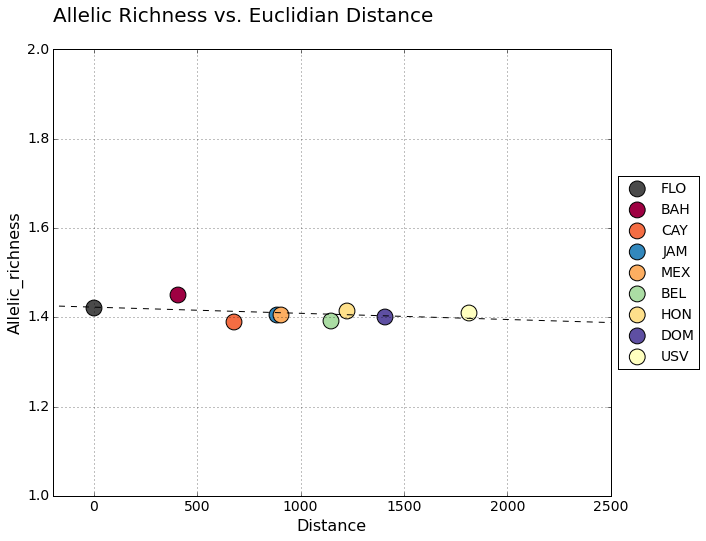

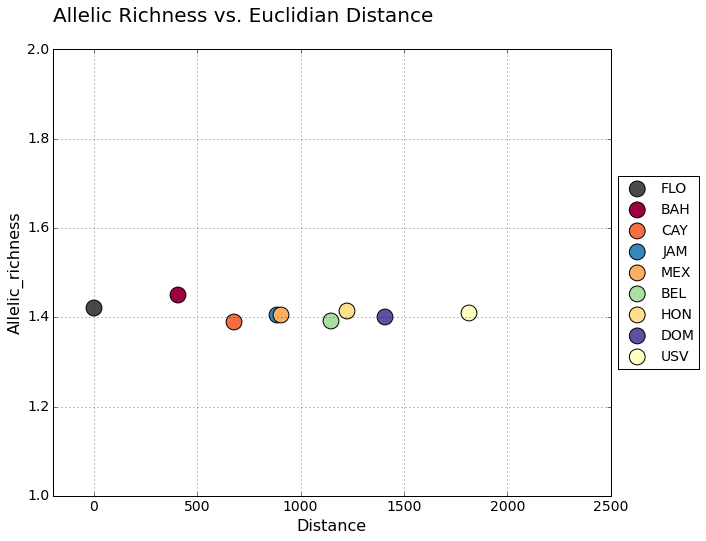

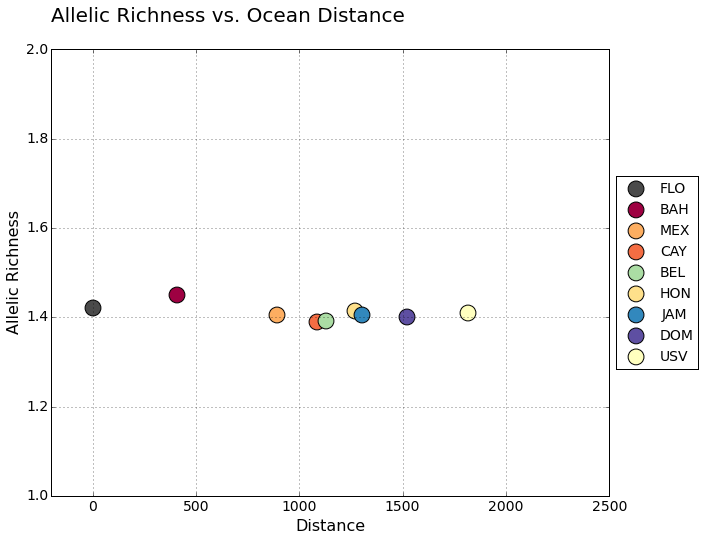

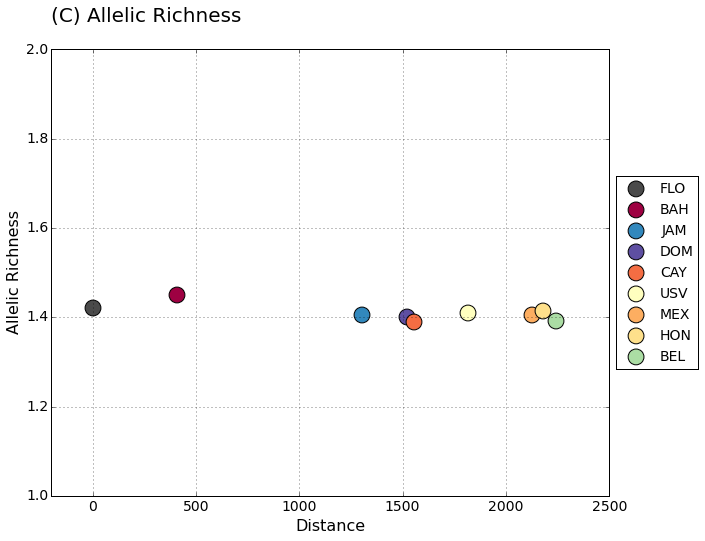

In [18]:
#Allelic Richness with a regression line (NOT significant, so then graph without)
plot_genetic_statistic_with_regression(b9_p8_r80_avg_sumstats_euc_dist, 'distance','a_richness', "Distance", "Allelic_richness", colors, "Allelic Richness vs. Euclidian Distance", '/Users/eleanorbors/Desktop/Manuscripts/Lionfish_ms1_modern/figures_for_paper/b9_p8_r80_Arich_vs._Euc_dist_with_reg.pdf', ymax = 2, ymin = 1)

#Allelic Richness vs. euclidian distance
plot_genetic_statistic_NO_regression(b9_p8_r80_avg_sumstats_euc_dist, 'distance','a_richness', "Distance", "Allelic_richness", colors, "Allelic Richness vs. Euclidian Distance", '/Users/eleanorbors/Desktop/Manuscripts/Lionfish_ms1_modern/figures_for_paper/b9_p8_r80_Arich_vs._Euc_dist.pdf', ymax = 2, ymin = 1)

#Allelic Richness vs. GE distance
plot_genetic_statistic_NO_regression(b9_p8_r80_avg_sumstats_ocean_dist, 'distance','a_richness', "Distance", "Allelic Richness", colors, "Allelic Richness vs. Ocean Distance", '/Users/eleanorbors/Desktop/Manuscripts/Lionfish_ms1_modern/figures_for_paper/b9_p8_r80_Arich_vs_ocean.pdf',  ymax = 2, ymin = 1)

#Allelic Richness vs. GIS distance 
plot_genetic_statistic_NO_regression(b9_p8_r80_avg_sumstats_modified_ocean_dist, 'distance','a_richness', "Distance", "Allelic Richness", colors, "(C) Allelic Richness", '/Users/eleanorbors/Desktop/Manuscripts/Lionfish_ms1_modern/figures_for_paper/b9_p8_r80_Arich_vs_modified_ocean.pdf',  ymax = 2, ymin = 1)

In [ ]:
###ALTERNATIVE DATASETS DATAFRAME CREATION

#lionfish_sumstats = make_sum_stats_dataframe(file_path, 'lionfish_sumstats')

#lionfish_sumstats
#avg_lionfish_sumstats = make_avg_sumstats_dataframe(summary_file_path,'avg_lionfish_sumstats', euclid_dist_dic)

#lionfish_sumstats = make_sum_stats_dataframe(file_path, 'lionfish_sumstats', ocean_dist_dic)

#o_dist_avg_lionfish_sumstats = make_avg_sumstats_dataframe(summary_file_path, 'avg_lionfish_sumstats', ocean_dist_dic)
#o_dist_avg_lionfish_sumstats

#b11_r80_o_dist_avg_sumstats = make_avg_sumstats_dataframe(b11_summary_file, 'b11_r80_o_dist_avg_sumstats', ocean_dist_dic)

#b9_r70_o_dist_avg_sumstats = make_avg_sumstats_dataframe(b9_r70_summary_filefath, 'b9_r70_o_dist_avg_sumstats', ocean_dist_dic)
#b9_r70_o_dist_avg_sumstats

#b11_r70_o_dist_avg_sumstats = make_avg_sumstats_dataframe(b11_r70_summary_filepath, 'b11_r70_o_dist_avg_sumstats', ocean_dist_dic)

#b9_p7_r80_avg_sumstats = make_avg_sumstats_dataframe(b9_p7_r80_summary_filepath, 'b9_p7_r80_avg_sumstats', ocean_dist_dic)
#b9_p7_r80_avg_sumstats

In [9]:

#plot_genetic_statistic_with_regression(o_dist_avg_lionfish_sumstats, 'distance','Hobs', "Distance", "Observed Heterozygosity", colors, "Observed Het vs. Around-Island Distance from Florida", '/Users/eleanorbors/Desktop/Manuscripts/Lionfish_ms1_modern/b9_r80_Hobs_vs._OceanDist.eps')
#plot_genetic_statistic_with_regression(b9_r70_o_dist_avg_sumstats, 'distance', 'Hobs', "Distance", "Observed Heterozygosity", colors, "Hobs with Around-Island Distance from FLO r70", '/Users/eleanorbors/Desktop/Manuscripts/Lionfish_ms1_modern/b9_r70_Hobs_vs._OceanDist.eps')

#plot_genetic_statistic_with_regression(b11_r80_o_dist_avg_sumstats, 'distance', 'Hobs', "Distance", "Observed Heterozygosity", colors, "Batch 11 Hobs with Around-Island Distance from FLO r80", '/Users/eleanorbors/Desktop/Manuscripts/Lionfish_ms1_modern/b11_r80_Hobs_vs._OceanDist.eps')


#plot_genetic_statistic_with_regression(b11_r70_o_dist_avg_sumstats, 'distance', 'Hobs', "Distance", "Observed Heterozygosity", colors, "Batch 11 Hobs with Around-Island Distance from FLO r70", '/Users/eleanorbors/Desktop/Manuscripts/Lionfish_ms1_modern/b11_r70_Hobs_vs._OceanDist.eps')

#plot_genetic_statistic_with_regression(b9_p7_r80_avg_sumstats, 'distance', 'Hobs', "Distance", "Observed Heterozygosity", colors, "Batch 9 Hobs with Around-Island Distance from FLO p7 r80", '/Users/eleanorbors/Desktop/Manuscripts/Lionfish_ms1_modern/b9_p7_r80_Hobs_vs._OceanDist.eps')

#plot_genetic_statistic_with_regression(b9_p8_r80_avg_sumstats, 'distance', 'Hobs', "Distance", "Observed Heterozygosity", colors, "Batch 9 Hobs with Around-Island Distance from FLO p8 r80", '/Users/eleanorbors/Desktop/Manuscripts/Lionfish_ms1_modern/b9_p8_r80_Hobs_vs._OceanDist.eps')

In [19]:
#plot_genetic_statistic_with_regression(o_dist_avg_lionfish_sumstats, 'distance','Hexp', "Distance", "Expected Heterozygosity", colors, "Expected Heterozygosity vs. Distance from Florida", "lower left")
#plot_genetic_statistic_NO_regression(o_dist_avg_lionfish_sumstats, 'distance','Hexp', "Distance", "Expected Heterozygosity", colors, "Expected Heterozygosity vs. Distance from Florida", '/Users/eleanorbors/Desktop/Manuscripts/Lionfish_ms1_modern/b9_r80_Hexp_vs_oDist.eps', "lower left")
#plot_genetic_statistic_NO_regression(b9_r70_o_dist_avg_sumstats, 'distance','Hexp', "Distance", "Expected Heterozygosity", colors, "Expected Heterozygosity vs. Distance from Florida r70", '/Users/eleanorbors/Desktop/Manuscripts/Lionfish_ms1_modern/b9_r70_Hexp_vs_oDist.eps', "lower left")

#plot_genetic_statistic_NO_regression(b11_r70_o_dist_avg_sumstats, 'distance','Hexp', "Distance", "Expected Heterozygosity", colors, "batch 11Expected Heterozygosity vs. Distance from Florida r70",'/Users/eleanorbors/Desktop/Manuscripts/Lionfish_ms1_modern/b11_r70_Hexp_vs_oDist.eps', "lower left")

#plot_genetic_statistic_with_regression(b9_p7_r80_avg_sumstats, 'distance', 'Hexp', "Distance", "Expected Heterozygosity", colors, "Batch 9 Hexp with Around-Island Distance from FLO p7 r80", '/Users/eleanorbors/Desktop/Manuscripts/Lionfish_ms1_modern/b9_p7_r80_Hexp_vs._OceanDist.eps')



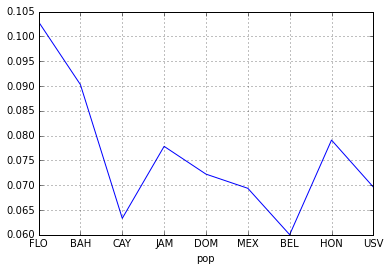

In [17]:
groups = lionfish_sumstats.groupby('pop', sort=False)

groups['Hobs'].mean().plot()

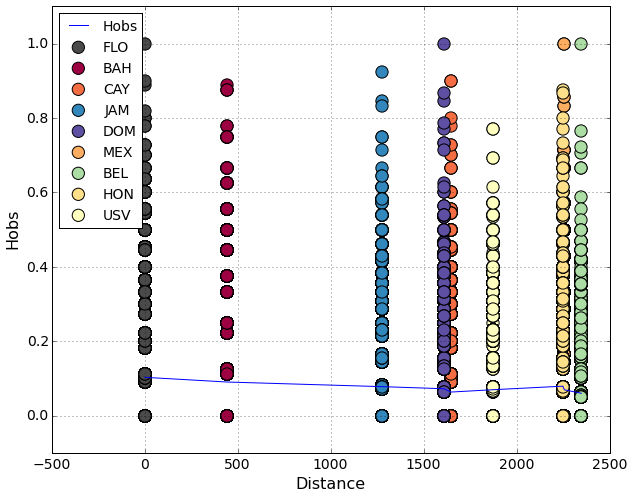

In [23]:
groups = lionfish_sumstats.groupby('pop', sort=False)

fig,ax= plt.subplots()

fig.set_size_inches(10,8)

for key, group in groups:
    
    group.plot(kind ='scatter', x='distance', y='Hobs', color = colors[key], ax=ax, label = key, marker = 'o', s = 150, 
               edgecolors='black', fontsize = 14)



lionfish_sumstats.groupby('distance')['Hobs'].mean().plot()

ax.legend(loc='upper left', fontsize=14, scatterpoints=1)
ax.set_ylim(-0.1, 1.1)
ax.set_xlim(-500, 2500)
plt.xlabel("Distance", fontsize = 16)
plt.ylabel("Hobs", fontsize = 16)

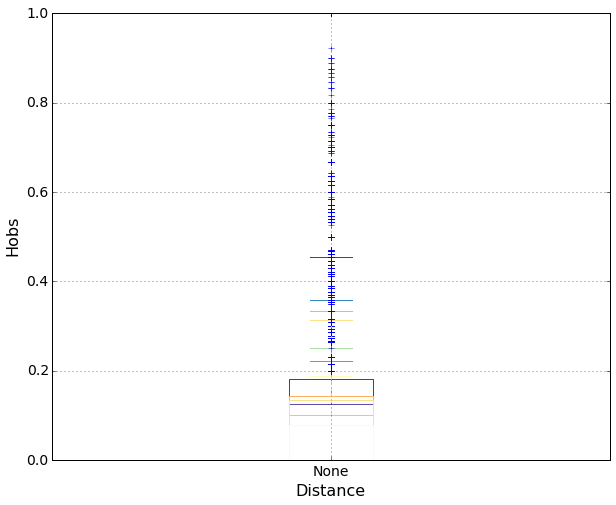

In [124]:
groups = lionfish_sumstats.groupby('pop', sort=False)

fig,ax= plt.subplots()

fig.set_size_inches(10,8)

for key, group in groups:
    group.plot(kind ='box', x = 'distance', y='Hobs', color = colors[key], ax=ax, label = key, fontsize = 14)

    ax.legend(loc='upper left', fontsize=14, scatterpoints=1)

plt.xlabel("Distance", fontsize = 16)
plt.ylabel("Hobs", fontsize = 16)

In [50]:

b9_r8_p80_sumstats_df = make_sum_stats_dataframe(b9_p8_r80_sumstats_filepath, 'b9_r8_p80_sumstats_df', ocean_dist_dic)

b9_r8_p80_sumstats_df


,batch,locus_id,Chr,BP,Col,pop,P_nuc,Q_nuc,N,P,...,Hexp,Exp Hom,Pi,Smoothed Pi,Smoothed Pi P-value,Fis,Smoothed Fis,Smoothed Fis P-value,Private,distance
0,9,102,un,9106,14,FLO,G,A,11,0.636364,...,0.4628,0.5372,0.4848,0,0,0.2500,0,0,0,0
1,9,102,un,9106,14,BAH,G,A,8,0.562500,...,0.4922,0.5078,0.5250,0,0,0.7619,0,0,0,442
2,9,102,un,9106,14,CAY,G,A,11,0.772727,...,0.3512,0.6488,0.3680,0,0,0.2588,0,0,0,1647
3,9,102,un,9106,14,JAM,G,A,12,0.666667,...,0.4444,0.5556,0.4638,0,0,0.2812,0,0,0,1277
4,9,102,un,9106,14,DOM,G,A,14,0.714286,...,0.4082,0.5918,0.4233,0,0,0.3250,0,0,0,1609
5,9,102,un,9106,14,BEL,G,A,16,0.750000,...,0.3750,0.6250,0.3871,0,0,0.6771,0,0,0,2347
6,9,102,un,9106,14,HON,G,A,13,0.846154,...,0.2604,0.7396,0.2708,0,0,0.4318,0,0,0,2248
7,9,102,un,9106,14,USV,G,A,13,0.769231,...,0.3550,0.6450,0.3692,0,0,0.5833,0,0,0,1874
8,9,122,un,10960,68,FLO,G,-,11,1.000000,...,0.0000,1.0000,0.0000,0,0,0.0000,0,0,0,0
9,9,122,un,10960,68,BAH,G,-,8,1.000000,...,0.0000,1.0000,0.0000,0,0,0.0000,0,0,0,442


In [23]:
def subset_dataframe_by_population(sumstats_df, population_name, output_df_name):
    output_df_name = sumstats_df.loc[sumstats_df['pop'] == population_name]
    return output_df_name


0.16808062874


{'boxes': [<matplotlib.lines.Line2D at 0x10e47f510>],
 'caps': [<matplotlib.lines.Line2D at 0x10e48b3d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x111de96d0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x111de9090>],
 'whiskers': [<matplotlib.lines.Line2D at 0x10e47f690>,
  <matplotlib.lines.Line2D at 0x10e47fd50>]}

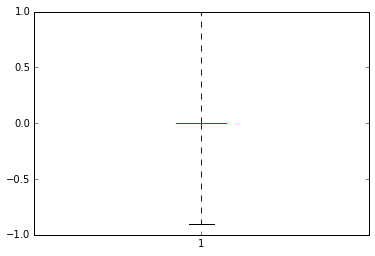

In [49]:

FLO_df_sumstats = subset_dataframe_by_population(b9_r8_p80_sumstats_df, 'FLO', 'FLO_df_sumstats')
print FLO_df_sumstats['Hobs'].std()

FLO_df_sumstats

#FLO_df_sumstats['Fis'].plot(kind = 'box')

#FLO_df_sumstats.plot(kind = 'scatter', x = 'distance',y = 'Fis')

plt.figure()
plt.boxplot(FLO_df_sumstats['Fis'], 0, 'rs', 1, 0.05)


#for i in population_list:
    

#FLO_Hobs
#FLO_Hobs.plot(kind ='box', x = 'distance', y='Hobs', ax=ax, label = key, fontsize = 14)

0.132964026844


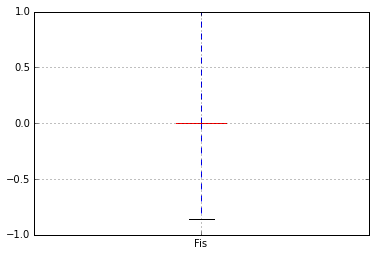

In [27]:

MEX_df_sumstats = subset_dataframe_by_population(b9_r8_p80_sumstats_df, 'MEX', 'MEX_df_sumstats')
print MEX_df_sumstats['Hobs'].std()

MEX_df_sumstats

MEX_df_sumstats['Fis'].plot(kind = 'box')